<a href="https://colab.research.google.com/github/tonyw54/GeorgeBrown/blob/main/Tony_Waterman_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tony Waterman (101199518)

In [ ]:
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


# Dataset Description

Plant disease detection via computer vision could be a very important to protecting the agriculture industry. This dataset contains 4235 images of healthy and/or diseased leaves. Within this dataset, there are 10 different plant species with a variety of leaf shapes and degrees of disease progression. There are 3 csv files: train, test, and sample_submission. The train file has one column being the image (with the image_id) and the other being the label (0: healthy and 1: for diseased), the test file only having the image column (no answers).

Files
train.csv - the training set

test.csv - the test set

Columns

Images - JPG image id

Labels - 0: healthy and 1: diseased

Data Source

Dataset modified from the "Healthy vs. Diseased Leaf Image Dataset" (License CC0: Public domain) on Kaggle at https://www.kaggle.com/datasets/amandam1/healthy-vs-diseased-leaf-image-dataset

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import zipfile
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import timm
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# download competition data
computer_vision_xm_path = kagglehub.competition_download('computer-vision-xm')

source_dir = '/root/.cache/kagglehub/competitions/computer-vision-xm'
destination_dir = '/content/computer-vision-xm'  # Create a folder in '/content/'

shutil.copytree(source_dir, destination_dir)

shutil.rmtree('/root/.cache/kagglehub/competitions/computer-vision-xm', ignore_errors=True)

print(f"Directory '{source_dir}' copied to '{destination_dir}' successfully.")

100%|██████████| 6.20G/6.20G [05:30<00:00, 20.2MB/s]

Extracting files...


Directory '/root/.cache/kagglehub/competitions/computer-vision-xm' copied to '/content/computer-vision-xm' successfully.


In [ ]:
def count_images(folder_path):
  image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')  # Add more if needed
  image_count = 0
  for root, _, files in os.walk(folder_path):
    for file in files:
      if file.lower().endswith(image_extensions):
        image_count += 1
  return image_count

folder_path = '/content/computer-vision-xm'
total_images = count_images(folder_path)
print(f"Total number of images: {total_images}")

Total number of images: 4236


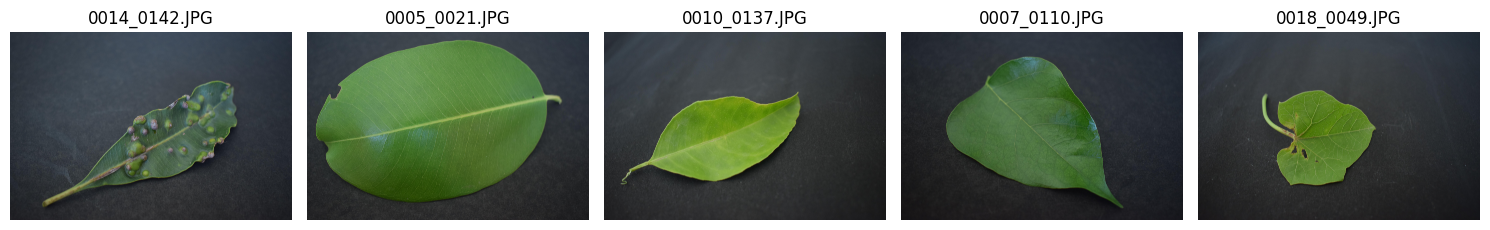

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Assuming images are in the '/content/computer-vision-xm/images' directory
image_dir = '/content/computer-vision-xm/images/kaggle/working/Reorganized_Data/images'

# Check if the directory exists
if os.path.exists(image_dir):
  image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

  # Display the first 5 images (or fewer if there are less than 5)
  num_images_to_display = min(5, len(image_files))

  plt.figure(figsize=(15, 5))  # Adjust figure size as needed
  for i in range(num_images_to_display):
    image_path = os.path.join(image_dir, image_files[i])
    try:
      img = mpimg.imread(image_path)
      plt.subplot(1, num_images_to_display, i + 1)  # Create subplots
      plt.imshow(img)
      plt.title(image_files[i])
      plt.axis('off')  # Hide axes
    except Exception as e:
      print(f"Error displaying image {image_files[i]}: {e}")

  plt.tight_layout()  # Adjust layout to prevent overlapping titles
  plt.show()
else:
  print(f"Error: Directory '{image_dir}' not found.")

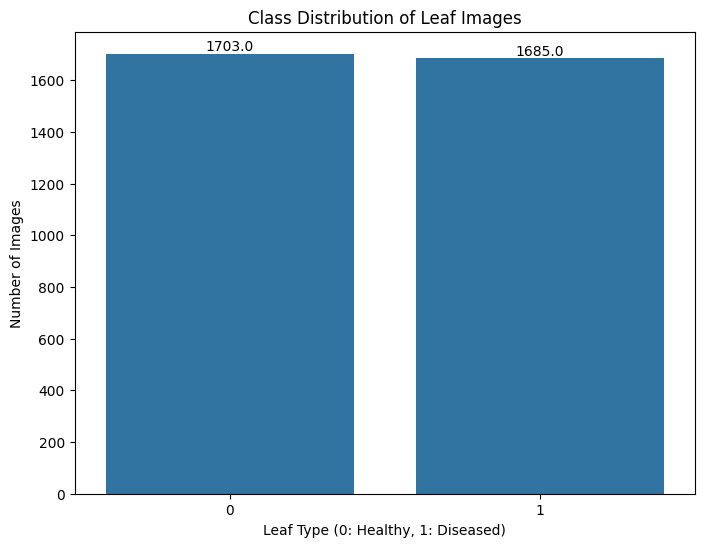

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training data
train_df = pd.read_csv('/content/computer-vision-xm/train.csv')

# Count the occurrences of each class (0: healthy, 1: diseased)
class_counts = train_df['Labels'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Labels', data=train_df)
plt.title('Class Distribution of Leaf Images')
plt.xlabel('Leaf Type (0: Healthy, 1: Diseased)')
plt.ylabel('Number of Images')

# Add labels above each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')


plt.show()

In [ ]:
class LeafDataset(Dataset):
    def __init__(self, img_dir, df, transform=None, is_test=False):
        self.img_dir = img_dir
        self.df = df
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)

        # Load image as numpy array for albumentations
        image = np.array(Image.open(img_path).convert('RGB'))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.is_test:
            return image, img_name
        else:
            label = self.df.iloc[idx, 2]
            return image, label

# Choice of Training Model
The best model, I found, was `efficientnetv2_rw_s`. This model had a good result in the Kaggle competition. The first time I ran this notebook, I got first place. Unfortunately, I probably won't have time to compete any more until after school ends.

In [ ]:
class ImprovedLeafClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ImprovedLeafClassifier, self).__init__()
        # Use EfficientNetV2 as backbone - stronger than ResNet18
        self.model = timm.create_model('efficientnetv2_rw_s', pretrained=True)

        # Freeze early layers
        for name, param in self.model.named_parameters():
            if "blocks.0" in name or "blocks.1" in name or "blocks.2" in name:
                param.requires_grad = False

        # Replace classifier head
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)


# Pre-processing
I tried various forms of data augmentation, including random cropping, horizonal flip, vertical flip, random rotate, and various kinds of noise.

In [ ]:
def create_data_loaders(img_dir, train_csv, test_csv, batch_size=16):
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)

    # More aggressive data augmentation
    train_transform = A.Compose([
        A.RandomResizedCrop(height=384, width=384, scale=(0.8, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0)),
            A.GaussianBlur(),
            A.MotionBlur(),
        ], p=0.3),
        A.OneOf([
            A.OpticalDistortion(),
            A.GridDistortion(),
        ], p=0.3),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(384, 384),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Stratified split with larger validation set
    train_df, val_df = train_test_split(
        train_df, test_size=0.15, random_state=42, stratify=train_df['Labels']
    )

    # Create datasets
    train_dataset = LeafDataset(img_dir, train_df, train_transform)
    val_dataset = LeafDataset(img_dir, val_df, val_transform)
    test_dataset = LeafDataset(img_dir, test_df, val_transform, is_test=True)

    # Create data loaders with appropriate batch sizes
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [ ]:
import time

# Lists to store accuracy and loss values
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

def train_model(model, train_loader, val_loader, num_epochs=20):
    start_time = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Use weighted loss if classes are imbalanced
    criterion = nn.CrossEntropyLoss()

    # Use AdamW with weight decay
    optimizer = optim.AdamW(
        [
            {'params': (p for n, p in model.named_parameters() if 'classifier' not in n), 'lr': 1e-4},
            {'params': (p for n, p in model.named_parameters() if 'classifier' in n), 'lr': 1e-3}
        ],
        weight_decay=0.01
    )

    # Cosine annealing scheduler with warmup
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[1e-4, 1e-3],
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos'
    )

    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Use mixed precision training
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_accuracy = 100 * correct / total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Early stopping with patience
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, 'best_leaf_classifier.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                break

        # Append values at the end of each epoch
        train_acc_history.append(train_accuracy)
        val_acc_history.append(val_accuracy)
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)
        end_time = time.time()  # Record end time
        epoch_time = end_time - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f} seconds')


Begin training for 20 epochs. Each epoch lasts for about 7 minutes on a GPU. Total training time was about an hour and a half.

In [ ]:
# Usage example
if __name__ == "__main__":
    # Initialize model and data loaders
    model = ImprovedLeafClassifier()

    # Paths to your data
    IMG_DIR = '/content/computer-vision-xm/images/kaggle/working/Reorganized_Data/images'
    TRAIN_CSV = '/content/computer-vision-xm/train.csv'
    TEST_CSV = '/content/computer-vision-xm/test.csv'

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        IMG_DIR, TRAIN_CSV, TEST_CSV, batch_size=32
    )

    # Train the model
    train_model(model, train_loader, val_loader)

model.safetensors:   0%|          | 0.00/96.5M [00:00<?, ?B/s]

<ipython-input-10-17260e19bf97>:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
<ipython-input-10-17260e19bf97>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/20]
Train Loss: 0.5243, Train Acc: 71.24%
Val Loss: 0.2346, Val Acc: 90.96%
Epoch [1/20] - Time: 256.06 seconds
Epoch [2/20]
Train Loss: 0.2387, Train Acc: 90.20%
Val Loss: 0.1618, Val Acc: 94.30%
Epoch [2/20] - Time: 514.87 seconds
Epoch [3/20]
Train Loss: 0.1590, Train Acc: 94.30%
Val Loss: 0.1173, Val Acc: 95.48%
Epoch [3/20] - Time: 768.28 seconds
Epoch [4/20]
Train Loss: 0.1330, Train Acc: 95.35%
Val Loss: 0.1031, Val Acc: 96.86%
Epoch [4/20] - Time: 1015.58 seconds
Epoch [5/20]
Train Loss: 0.1063, Train Acc: 96.01%
Val Loss: 0.0872, Val Acc: 96.86%
Epoch [5/20] - Time: 1262.84 seconds
Epoch [6/20]
Train Loss: 0.0951, Train Acc: 96.80%
Val Loss: 0.0894, Val Acc: 96.27%
Epoch [6/20] - Time: 1510.29 seconds
Epoch [7/20]
Train Loss: 0.0726, Train Acc: 97.46%
Val Loss: 0.0833, Val Acc: 97.25%
Epoch [7/20] - Time: 1757.75 seconds
Epoch [8/20]
Train Loss: 0.0770, Train Acc: 97.19%
Val Loss: 0.0891, Val Acc: 96.66%
Epoch [8/20] - Time: 2007.81 seconds
Epoch [9/20]
Train Loss: 0.

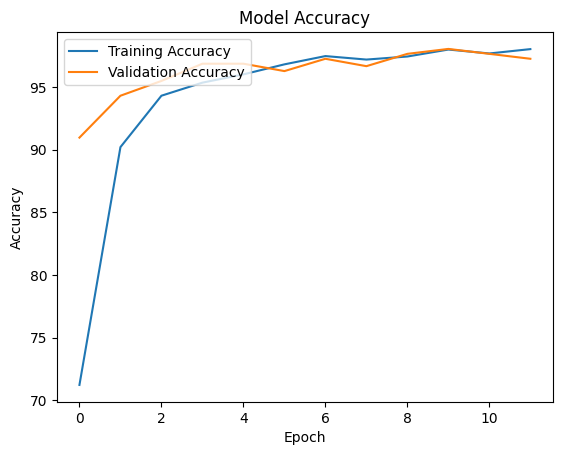

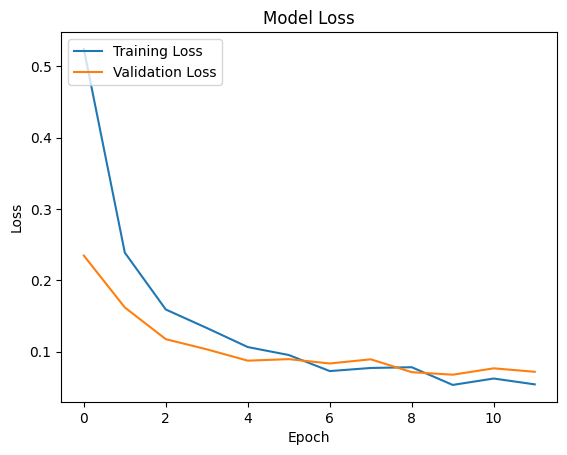

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Model Prediction and Evaluation

Now that our model is built, let's run it on the validation dataset. This data was not used during training or testing. On the validation set, the accuracy is `98.04%`, which is outstanding.

In [ ]:
# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedLeafClassifier()
checkpoint = torch.load('best_leaf_classifier.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Evaluate the model on the validation dataset
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f"Validation Accuracy: {val_accuracy:.2f}%")

<ipython-input-13-3e103018e75d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_leaf_classifier.pth', map_location=device)


Validation Accuracy: 98.04%


The training was done on a GPU in colab. The training loop took about an hour. Early stopping kicked in after 13 epochs during this run. During this training time the GPU was running at a fairly high level. System RAM was fairly low, since the data was moving quickly to the GPU. Hard disk usage was also low, since the disk was only holding the training, test and validation images.

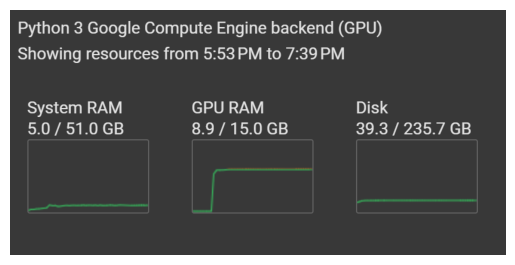

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('GPU_Usage.png')
plt.imshow(img)
plt.axis('off')
plt.show()

# Next steps
In this training system, we had a very good result. This was due to the quality of the data on Kaggle. We used the efficientnetv2_rw_s model from Hugging Face. Next steps would be to find other models from Hugging Face, as well as some pre-built models from Keras Hub and the PyTorch repository. I would also like to try some Yolo models to see how they do. In the Kaggle leaderboard below, I (tonyw54) am actually now tied for second place after only 3 attempts. My last attempt was 20 days ago, since I haven't had much time to work on this with my new job and school. I'll definitely do a few more submissions before the end of the year to see if I can get into first place and win this competition.

In [6]:
img = mpimg.imread('kaggle.png')
plt.figure(figsize=(200, 150))
plt.imshow(img)
plt.axis('off')
plt.show()


# Lessons Learned
The main lesson learned was, when using a pre-trained model, the choice of **which** pre-trained model made all the difference. Various types of optimization strategies can be used, but the choice of model is the first thing to be concerned with. After the best model is chosen, then different forms of optimizatin can be tried.